In [ ]:
# NOT FINISHED CHANGING TO USE BOUNDARY CONDITIONS FOR ALL COMPARISONS WITH THE FAR FIELD

In [1]:
# %matplotlib notebook 
# Uncomment above for interactive plots
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sympy as sym
from sympy import *
from scipy import integrate
import scipy.optimize
import scipy.special
cmap = plt.get_cmap("tab10")
from matplotlib import cm
import itertools
import os, time
from scipy.optimize import fsolve
import scipy.optimize as optimize

def Gauss(x, A, u, s, C):
    return A*np.exp(-(x-u)**2/(2*s**2))+C

def Gauss0(x, A, u, s):
    return A*np.exp(-(x-u)**2/(2*s**2))

def Sig(x, A, u, f, C):
    return A*scipy.special.erf((x-u)/f)+C

def Lor(x, A, u, T, C):
    return np.pi*T/2*A*T/(2*np.pi*((x-u)**2+(T**2)/4)) + C

def LoadFrame(FrameName):
    Frame = []
    OUT = ['LBU2','P1U2','P2U2','LTU2','LBS2']
    for nOUT in range(0,len(OUT)):
        try:
            temp = np.load(r'C:\Users\21705319\ Python Scripts\AbaqusXYData\Final'+'\\'+FrameName+'_'+OUT[nOUT]+'.npy') 
            Frame.append(temp[np.argsort(temp[:, 0])])
        except:
            print('File '+FrameName+'.npy can not be found')
            return []
    return Frame

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

Have:
- XY data file for each (Sample,Layer,Preload,Output) combination
- Different number of points for the outputs depending on where they're taken from

Want:
- Ability to specify any 2 variables for a 2D plot or any 3 for a 3D plot
- Import relevant results, generate plot, delete variables from memory
- Ability to loop the above to generate ranges of results

Plan:
- Specify controlled variables and their value for the plot
- Specify axis variables
- Specify required output style and any metrics
- Import required data
- Make any transformations required
- Find any single points from XY data required
- Visualise results

In [2]:
# ID: Inclusion Depth
# IT: Inclusion Thickness
# IR: Inclusion Radius
# IE: Inclusion Elasticity
# LT: Layer Thickness
# LE: Layer Elasticity
# P: Preload (strain in the layer in the far field)
# OUT: various 2D plots with radial coordinate
    # LBU2: Layer Bottom Axial Displacement
    # P1U2: 1st Particle Layer Axial Displacement (only valid for layer thickness > 500um)
    # P2U2: 2nd Particle Layer Axial Displacement (only valid for layer thickness > 1mm)
    # LTU2: Layer Top Axial Displacement (can be treated as a single point but data is a 2d Plot)
    # LBS2: Layer Bottom Axial Stress

In [3]:
DisplacementDiff_LB = []
StressFWHM_LB = []
StressContrast_LB = []
StressContrastRatio_LB = []
StressFWHM_OP = []
StressContrast_OP = []
StressContrastRatio_OP = []
Variable_Coords = []
Coords = []

Preload = [0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2,0.225,0.25,0.275,0.3] # Strain in the layer
PreloadN = ['2p5%','5%','7p5%','10%','12p5%','15%','17p5%','20%','22p5%','25%','27p5%','30%']
LayerElasticity = [25000]
LayerElasticityN = ['25kPa']
BackgroundElasticity = 25000
InclusionElasticity = [50000,5*25000,7.5*25000,10*25000] # Doesn't converge after 7.5x background
InclusionElasticityN = ['2x','5x','7p5x','10x']
LayerThickness = [0.01,0.0075,0.005,0.004,0.003,0.002,0.001,0.0005]
LayerThicknessN = ['10','7p5','5','4','3','2','1','0p5']
SampleThickness = 0.005
InclusionDepth = [60e-06,500e-06,0.001,0.002] # Minimum 60e-06
InclusionDepthN = ['0p05','0p5','1','2']
InclusionThickness = [500e-06,0.001,0.002,0.003] # Minimum 10e-06, allowed to have inclusion touching bottom of sample
InclusionThicknessN = ['0p5','1','2','3']
InclusionRadius = [500e-06,0.001,0.002,0.003] # Minimum 10e-06
InclusionRadiusN = ['0p5','1','2','3']

# Set controlled variables using nVar, others will change via loop below
ModelName = 'Mesh17-Final'
IDN = ['0p05','0p5','1','2']
ID = [60e-06,500e-06,0.001,0.002] # yes the first depth is actually 60um, I started with a 50um naming policy and can't change it any more
ITN = ['0p5','1','2','3']
IT = [500e-06,0.001,0.002,0.003] # Minimum 10e-06, allowed to have inclusion touching bottom of sample
IRN = ['0p5','1','2','3']
IR = [500e-06,0.001,0.002,0.003] # Minimum 10e-06
IEN = ['2x','5x','7p5x','10x']
IE = [50000,5*25000,7.5*25000,10*25000] # Doesn't converge after 7.5x background
LTN = ['10','7p5','5','4','3','2','1','0p5']
LT = [0.01,0.0075,0.005,0.004,0.003,0.002,0.001,0.0005]
LEN = ['25kPa']
LE = [25000]
PN = ['2p5%','5%','7p5%','10%','12p5%','15%','17p5%','20%','22p5%','25%','27p5%','30%']
P = [0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2,0.225,0.25,0.275,0.3]
PN = ['15%']
P = [0.15]
OUTN = ['LBU2','P1U2','P2U2','LTU2','LBS2']

#plt.figure(figsize=(13,9)) # for checking intermediate steps
#ax = plt.subplot(1,1,1)
#plt.plot(x, y)

Frames = []
for nID in range(0,len(IDN)):
    for nIT in range(0,len(ITN)):
        for nIR in range(0,len(IRN)):
            for nIE in range(0,len(IEN)):
                for nLT in range(0,len(LTN)):
                    for nLE in range(0,len(LEN)):
                        for nP in range(0,len(PN)):
# Use index and list variables in for loops to control what is being plotted
# Need to change things above here to control what variables are used
                            def s22(NE_s):                     # Needs to change with layer elasticity
                                LE_s = np.log(NE_s+1)
                                return LE[nLE]*LE_s

                            Variable_Coords.append([nID,nIT,nIR,nIE,nLT,nLE,nP])
                            Coords.append([ID[nID],IT[nIT],IR[nIR],IE[nIE],LT[nLT],LE[nLE],P[nP]])
                            FrameName = ModelName+'_ID_'+IDN[nID]+'_IT_'+ITN[nIT]+'_IR_'+IRN[nIR]+'_IE_'+IEN[nIE]+'_LT_'+LTN[nLT]+'_LE_'+LEN[nLE]+'_P_'+PN[nP]
                            temp = LoadFrame(FrameName)
                            if temp == []:
                                DisplacementDiff_LB.append(np.nan)
                                StressFWHM_LB.append(np.nan)
                                StressContrast_LB.append(np.nan)
                                StressContrastRatio_LB.append(np.nan)
                                StressFWHM_OP.append(np.nan)
                                StressContrast_OP.append(np.nan)
                                StressContrastRatio_OP.append(np.nan)
                                continue
                            
                            # Displacement Variables Processing
                            DisplacementDiff_LB.append(temp[0][0,1]-(-P[nP]*SampleThickness))
                            
                            # Stress Variables LB
                            x = moving_average(temp[4][:,0],20)
                            y = moving_average(temp[4][:,1],20)
                            x = moving_average(x,20)
                            y = moving_average(y,20)
                            # Stress Contrast
                            StressContrast_LB.append(y[0]/(BackgroundElasticity*np.log(1-P[nP])))
                            # Stress FWHM
                            g = np.gradient(y,x)
                            m = max(g) # max value
                            mi = (np.where(g == m))[0][0] # index of max value
                            mx = x[mi] # x coord of max value
                            g2 = np.abs(g-m/2)
                            if mi>0:
                                lg = min(g2[:mi])
                            else:
                                lg = g2[mi]
                            li = (np.where(g2==lg))[0][0]
                            lx = x[li]
                            rg = min(g2[mi:])
                            ri = (np.where(g2==rg))[0][0]
                            rx = x[ri]
                            StressFWHM_LB.append(np.abs(rx-lx))
                                
                            # Stress variables for OP
                            x = moving_average(temp[0][:,0],20)
                            y = moving_average(s22((np.interp(temp[0][:,0], temp[3][:,0], temp[3][:,1]) - temp[0][:,1])/LT[nLT]),20)
                            # Stress Contrast (Contrast Ratio)
                            StressContrast_OP.append(y[0]/(BackgroundElasticity*np.log(1-P[nP])))
                            # Stress Contrast Ratio (Accuracy)
                            try:
                                StressContrastRatio_OP.append(1-np.abs(1-StressContrast_OP[-1]/StressContrast_LB[-1]))
                            except:
                                StressContrastRatio_OP.append(np.nan)
                            # Stress FWHM
                            g = np.gradient(y,x)
                            m = max(g) # max value
                            mi = (np.where(g == m))[0][0] # index of max value
                            mx = x[mi] # x coord of max value
                            g2 = np.abs(g-m/2)
                            if mi>0:
                                lg = min(g2[:mi])
                            else:
                                lg = g2[mi]
                            li = (np.where(g2==lg))[0][0]
                            lx = x[li]
                            rg = min(g2[mi:])
                            ri = (np.where(g2==rg))[0][0]
                            rx = x[ri]
                            StressFWHM_OP.append(np.abs(rx-lx))


#plt.xlim([0.0015,0.0045])
#plt.ylim([-0.1e6,0.7e7])
#handles, labels = ax.get_legend_handles_labels()
#plt.grid()
#plt.show()




File Mesh17-Final_ID_2_IT_3_IR_2_IE_7p5x_LT_10_LE_25kPa_P_15%.npy can not be found
File Mesh17-Final_ID_2_IT_3_IR_2_IE_7p5x_LT_7p5_LE_25kPa_P_15%.npy can not be found


In [ ]:
StressFWHM_OP[0]


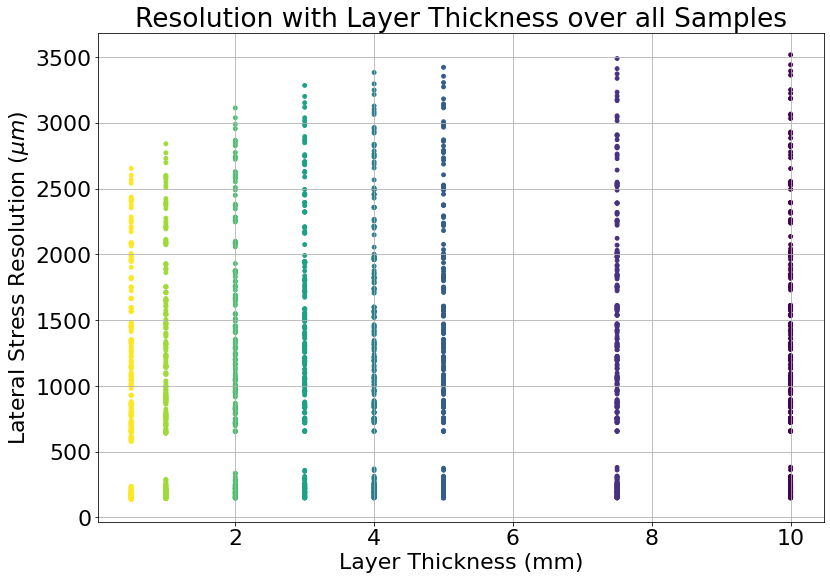

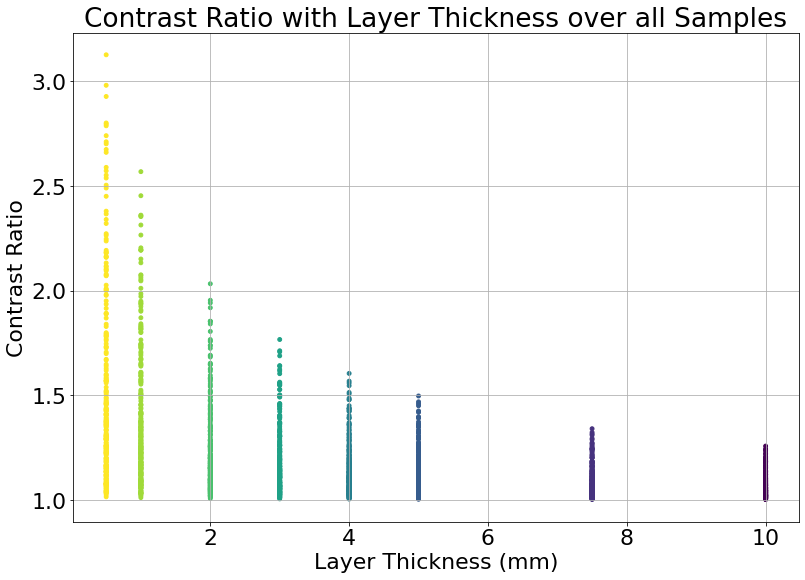

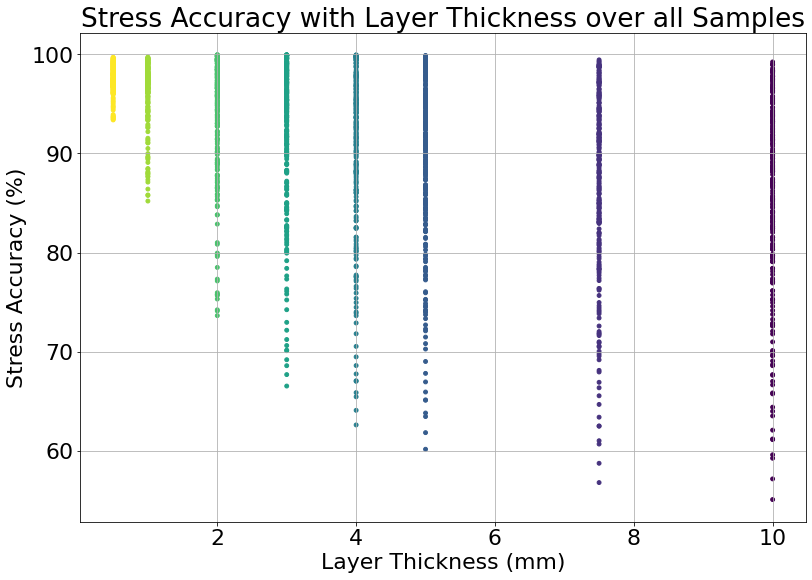

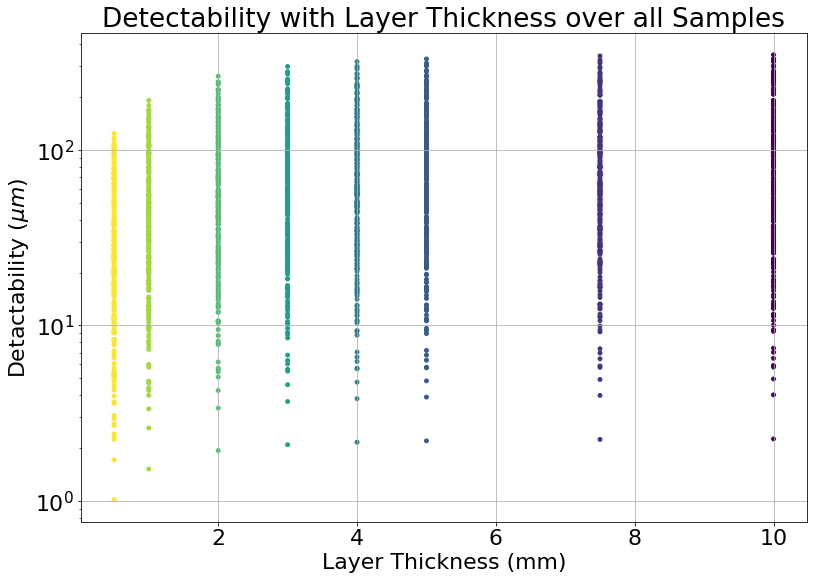

In [5]:
%matplotlib inline

plt.rcParams.update({'font.size': 22})

plt.figure(figsize=(13,9))
ax = plt.subplot(1,1,1)
plt.scatter(np.asarray(Coords)[:,4]*10**3, np.asarray(StressFWHM_OP)*10**6, s=15, c=np.asarray(Variable_Coords)[:,4])
plt.title("Resolution with Layer Thickness over all Samples")
plt.xlabel("Layer Thickness (mm)")
plt.ylabel("Lateral Stress Resolution ($\mu m$)")
plt.grid()
plt.show()

plt.figure(figsize=(13,9))
ax = plt.subplot(1,1,1)
plt.scatter(np.asarray(Coords)[:,4]*10**3, np.asarray(StressContrast_OP), s=15, c=np.asarray(Variable_Coords)[:,4])
plt.title("Contrast Ratio with Layer Thickness over all Samples")
plt.xlabel("Layer Thickness (mm)")
plt.ylabel("Contrast Ratio")
plt.grid()
plt.show()

plt.figure(figsize=(13,9))
ax = plt.subplot(1,1,1)
plt.scatter(np.asarray(Coords)[:,4]*10**3, np.asarray(StressContrastRatio_OP)*100, s=15, c=np.asarray(Variable_Coords)[:,4])
plt.title("Stress Accuracy with Layer Thickness over all Samples")
plt.xlabel("Layer Thickness (mm)")
plt.ylabel("Stress Accuracy (%)")
plt.grid()
plt.show()

plt.figure(figsize=(13,9))
ax = plt.subplot(1,1,1)
plt.scatter(np.asarray(Coords)[:,4]*10**3, np.asarray(DisplacementDiff_LB)*10**6, s=15, c=np.asarray(Variable_Coords)[:,4])
plt.title("Detectability with Layer Thickness over all Samples")
plt.xlabel("Layer Thickness (mm)")
plt.ylabel("Detactability ($\mu m$)")
plt.yscale("log")
plt.grid()
plt.show()